In [43]:
import comet_ml 
import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
from torch.nn.utils import weight_norm
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import numpy as np



### Simple Net Architecture
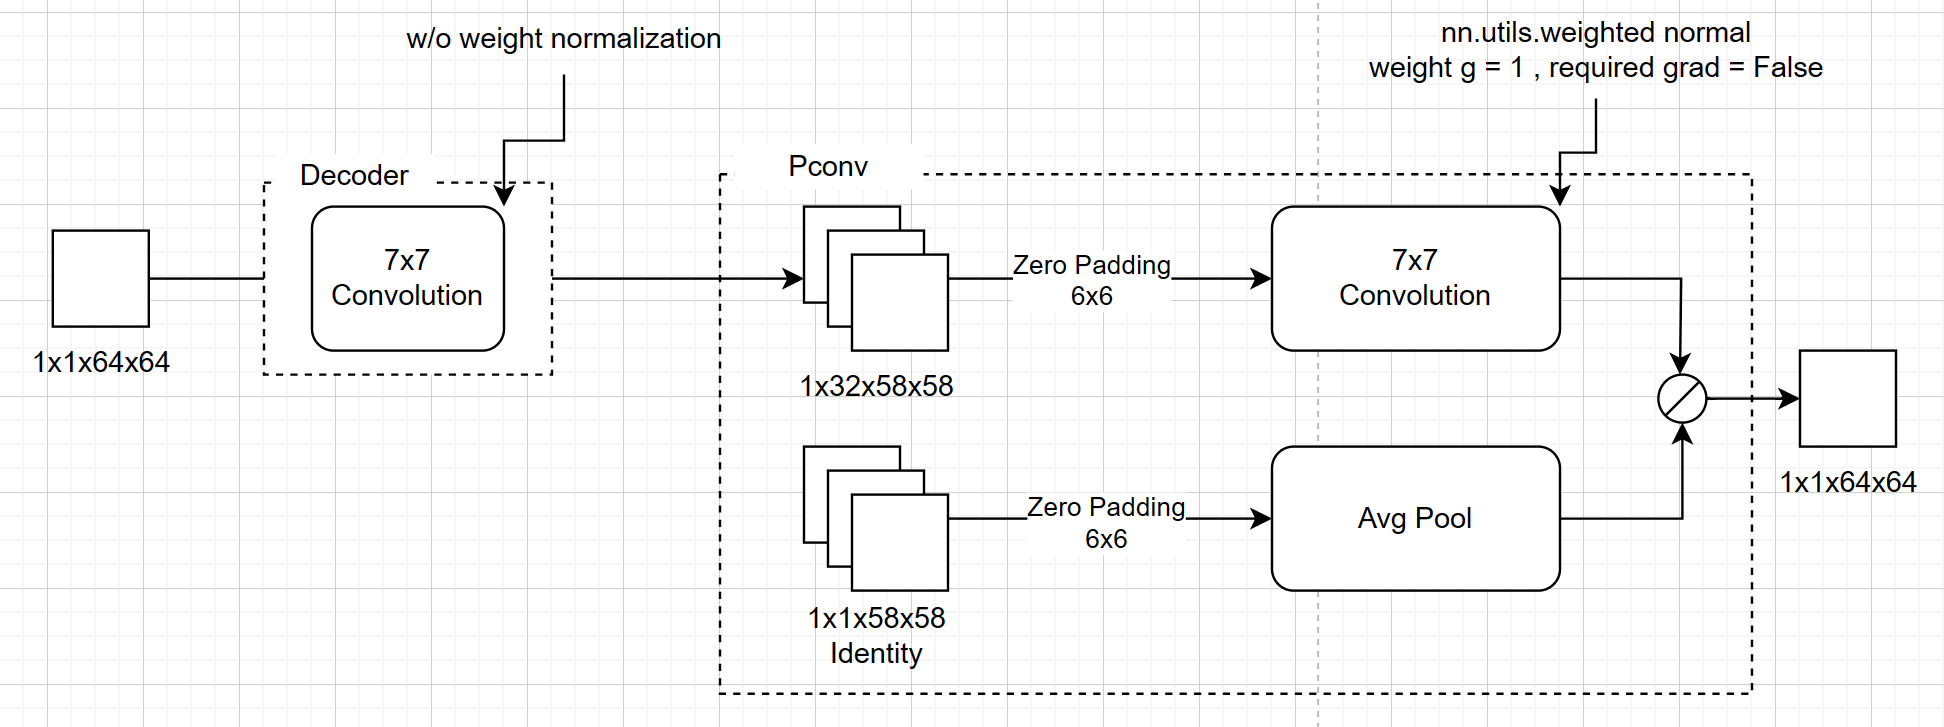

In [9]:
class SimpleNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.krnl_size = 7
        self.decoder = nn.Conv2d(1,32,self.krnl_size,bias=False)
        self.pconv = nn.Conv2d(32,1,self.krnl_size,padding=(6,6),bias=False)
        self.wn_pconv = weight_norm(self.pconv,name='weight')
        self.wn_pconv.weight_g = nn.Parameter(torch.ones_like(self.wn_pconv.weight_g))
        self.wn_pconv.weight_g.requires_grad = False 
        self.avgpool = nn.AvgPool2d(self.krnl_size,stride=1)
        #Partial Convolution Module 
    def forward(self, x, mode = 'train'):
        p = self.krnl_size-1
        x = self.decoder(x)
        latent = x
        n,c,h,w = x.shape
        mask = torch.ones(n,1,h,w).to(x)
        x = self.wn_pconv(x)
        mask = self.avgpool(F.pad(mask,(p,p,p,p)))
        # print(self.wn.weight_g, self.wn.weight_g.requires_grad)
        # return x, latent
        return x/mask, latent

model = SimpleNet()
summary(model, (1,64,64))
# print(model.wn.weight_g, model.wn.weight_g.requires_grad)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 58, 58]          1,568
├─Conv2d: 1-2                            [-1, 1, 64, 64]           (1,569)
├─AvgPool2d: 1-3                         [-1, 1, 64, 64]           --
Total params: 3,137
Trainable params: 1,568
Non-trainable params: 1,569
Total mult-adds (M): 5.28
Input size (MB): 0.02
Forward/backward pass size (MB): 0.85
Params size (MB): 0.01
Estimated Total Size (MB): 0.88


c:\Users\exhik\anaconda3\envs\kris\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 58, 58]          1,568
├─Conv2d: 1-2                            [-1, 1, 64, 64]           (1,569)
├─AvgPool2d: 1-3                         [-1, 1, 64, 64]           --
Total params: 3,137
Trainable params: 1,568
Non-trainable params: 1,569
Total mult-adds (M): 5.28
Input size (MB): 0.02
Forward/backward pass size (MB): 0.85
Params size (MB): 0.01
Estimated Total Size (MB): 0.88

### ResNet Architecture
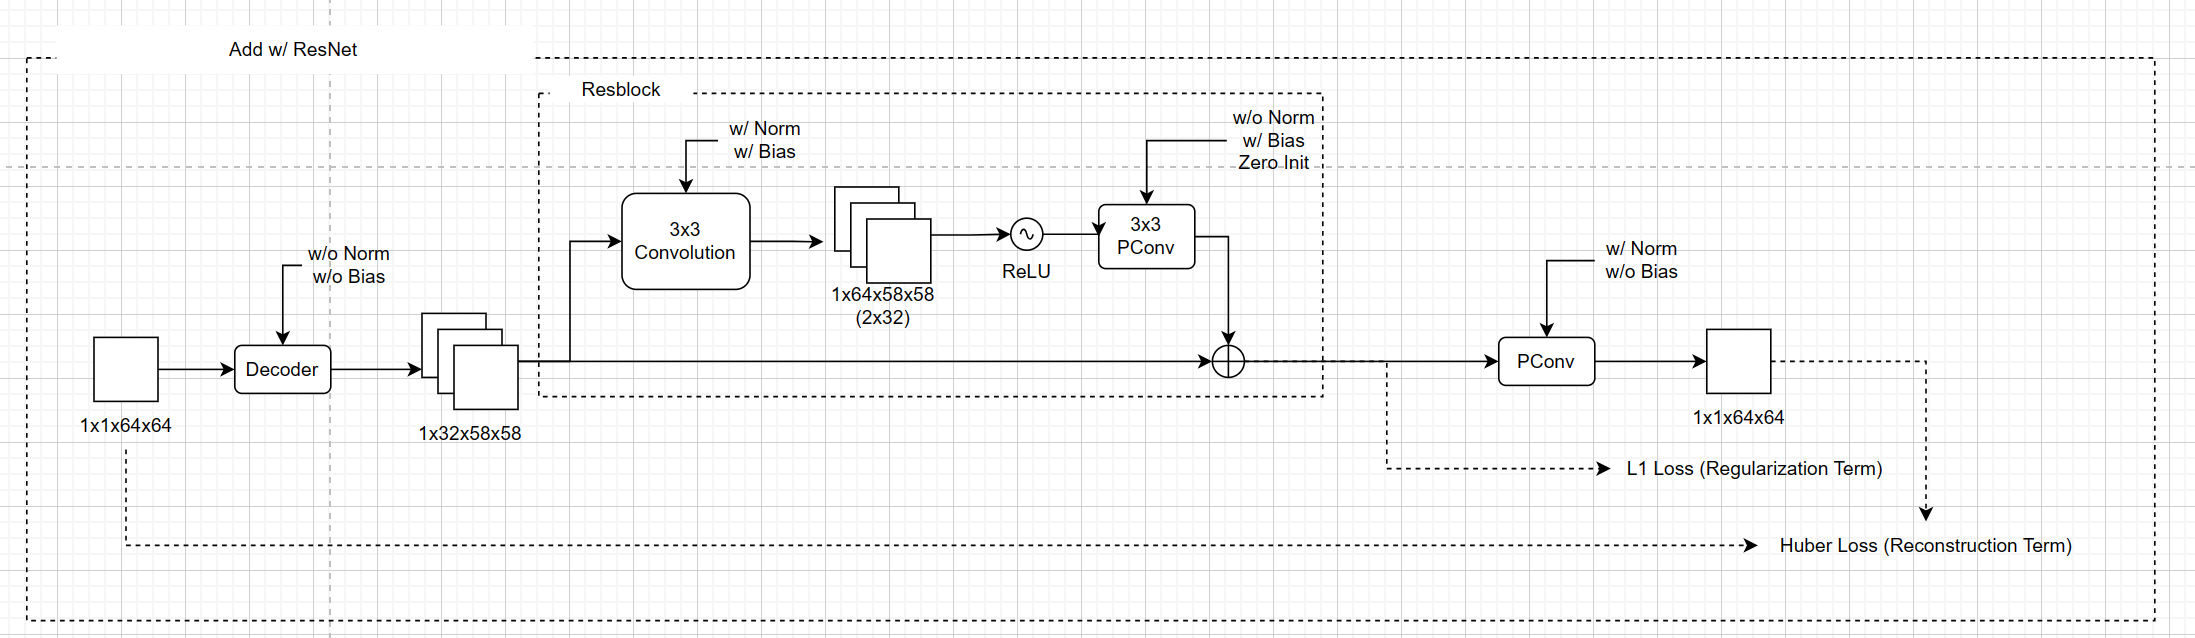

In [39]:
class ResBlock(nn.Module):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.krnl_size = 3 
        self.pad_size = (self.krnl_size - 1, self.krnl_size - 1)
        self.conv = nn.Conv2d(32,64,self.krnl_size,bias=True)
        self.wn_conv = nn.utils.weight_norm(self.conv,name='weight')
        self.wn_conv.weight_g = nn.Parameter(torch.ones_like(self.wn_conv.weight_g))
        self.wn_conv.weight_g.requires_grad = False 
        self.relu = nn.ReLU()
        self.pconv = nn.Conv2d(64,32,self.krnl_size,padding =self.pad_size,bias=True)
        self.pconv.weight.data.fill_(0) #zero initialization
        self.avgpool = nn.AvgPool2d(self.krnl_size,stride=1)
    def forward(self, x):
        p = self.krnl_size-1
        z  = self.wn_conv(x)
        z = self.relu(z)
        n , _, h, w = z.shape 
        mask = torch.ones(n,1 , h, w).to(z)
        z = self.pconv(z)
        mask = self.avgpool(F.pad(mask,(p, p, p, p)))
        z = z/mask
        return z+x
    
class ResNet(nn.Module):
    def __init__(self, n_res_block = 3) -> None:
        super().__init__()
        self.krnl_size = 7
        self.pad_size = (self.krnl_size-1, self.krnl_size-1)
        self.n_res_block = n_res_block    
        self.decoder = nn.Conv2d(1,32,self.krnl_size,bias=False)
        
        #Residual Part 
        self.res_block = nn.Sequential(*[ResBlock() for _ in range(self.n_res_block)])
        #End of Residual Part
        
        
        self.pconv = nn.Conv2d(32,1,self.krnl_size,padding=self.pad_size,bias=False)
        self.wn_pconv = nn.utils.weight_norm(self.pconv,name='weight')
        self.wn_pconv.weight_g = nn.Parameter(torch.ones_like(self.wn_pconv.weight_g))
        self.wn_pconv.weight_g.requires_grad = False 
        self.avgpool = nn.AvgPool2d(self.krnl_size,stride=1)
        
    def forward(self, x, mode = 'train'):
        x = self.decoder(x)
        p = self.krnl_size-1
        x = self.res_block(x)     
        latent = x
        n,c,h,w = x.shape
        mask = torch.ones(n,1,h,w).to(x)
        x = self.wn_pconv(x)
        mask = self.avgpool(F.pad(mask,(p,p,p,p)))
        # print(self.wn.weight_g, self.wn.weight_g.requires_grad)

        return x/mask , latent

            
    
model = ResNet()
summary(model, (1,64,64))
# print(model.wn.weight_g, model.wn.weight_g.requires_grad)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 58, 58]          1,568
├─Sequential: 1-2                        [-1, 32, 58, 58]          --
|    └─ResBlock: 2-1                     [-1, 32, 58, 58]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (18,560)
|    |    └─ReLU: 3-2                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-3                  [-1, 32, 58, 58]          18,464
|    |    └─AvgPool2d: 3-4               [-1, 1, 58, 58]           --
|    └─ResBlock: 2-2                     [-1, 32, 58, 58]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 56, 56]          (18,560)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 32, 58, 58]          18,464
|    |    └─AvgPool2d: 3-8               [-1, 1, 58, 58]           --
|    └─ResBlock: 2-3                     [-1, 32, 58, 58]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 58, 58]          1,568
├─Sequential: 1-2                        [-1, 32, 58, 58]          --
|    └─ResBlock: 2-1                     [-1, 32, 58, 58]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (18,560)
|    |    └─ReLU: 3-2                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-3                  [-1, 32, 58, 58]          18,464
|    |    └─AvgPool2d: 3-4               [-1, 1, 58, 58]           --
|    └─ResBlock: 2-2                     [-1, 32, 58, 58]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 56, 56]          (18,560)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 32, 58, 58]          18,464
|    |    └─AvgPool2d: 3-8               [-1, 1, 58, 58]           --
|    └─ResBlock: 2-3                     [-1, 32, 58, 58]     

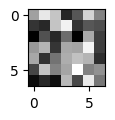

In [14]:
### visualize the kernels in Pconv
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

kernels = model.wn_pconv.weight.cpu().detach().clone()
visTensor(kernels)


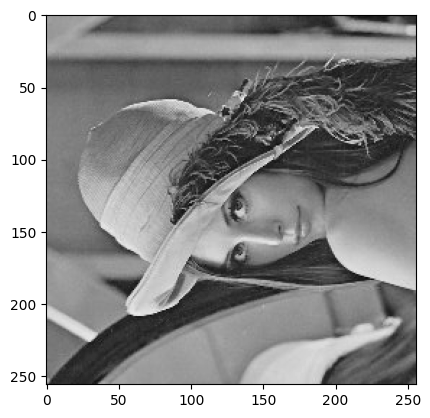

In [42]:

class RandomTranspose(torch.nn.Module):
    """Transpose the given image randomly with a given probability.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability of the image being transposed. Default value is 0.5
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be transposed.

        Returns:
            PIL Image or Tensor: Randomly transposed image.
        """
        if torch.rand(1) < self.p:
            return img.transpose(Image.TRANSPOSE)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

#Example Usage
image_path = r'C:\Users\exhik\workspace\TANAKA-s_Lab\Dataset\train\lena.jpg'
image = Image.open(image_path)

transform = RandomTranspose(p=0.5)
transformed_image = transform(image)
plt.imshow(transformed_image,cmap='gray')  # Show the transformed image


In [36]:

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        input_images = []
        output_iamges = []
        patch_size = 8
        for _ in range(patch_size):
            if self.transform:
                input_images.append(self.transform(image))
                output_iamges.append(self.transform(image))
        return input_images, output_iamges
    
# Example usage
train_data_transform = transforms.Compose([
    transforms.RandomCrop((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    RandomTranspose(p=0.5),
    transforms.ToTensor(),
])

test_data_transform = transforms.Compose([
    transforms.RandomCrop((128, 128)),
    transforms.ToTensor(),
])

Sparse Coding's optimization function :
$$ \underset{x_m}{\text{arg min}} \frac{1}{2} \left\| \sum_m d_m \cdot x_m - s \right\|_2^2 + \lambda \sum_m \|x_m\|_1 $$


In [33]:
class SCLoss(nn.Module):
    def __init__(self, lmbda):
        super(SCLoss, self).__init__()
        self.lmbda = lmbda
    def forward(self, input, target, latent):
        assert input.shape==target.shape
        loss_l2 = 0.5*torch.norm(target-input)**2
        loss_huber = F.huber_loss(input,target,delta=0.02)
        loss_norm = torch.norm(latent)
        losses = {'Reconstruction':loss_huber, 'Regularization':loss_norm}
        return loss_l2+self.lmbda*loss_norm, losses
        

In [44]:
losses = []
recon_losses = []
regu_losses = []
outputs = []
latents = []
def train (model, dataloader, criterion, optimizer, epoch, device, exp):
    s_loss = 0
    s_recon_loss = 0 
    s_regu_loss = 0
    for inputs, targets in dataloader:
        for input, target in zip(inputs, targets):
            input = input.to(device)
            target = target.to(device)
            assert len(input.shape) == 4
            optimizer.zero_grad()
            output, latent = model(input)
            loss, loss_detail = criterion(output, target, latent)
            loss.backward()
            optimizer.step()
            s_loss+=loss.item()
            s_recon_loss+=loss_detail['Reconstruction'].item()
            s_regu_loss+=loss_detail['Regularization'].item()
    exp.log_metric('Loss', s_loss,step=epoch)
    exp.log_metric('Recon_Loss', s_recon_loss,step=epoch)
    exp.log_metric('Regu_Loss', s_regu_loss,step=epoch)
                
def test(model, dataloader, criterion, device, epoch, exp):
    s_loss = 0
    s_recon_loss = 0 
    s_regu_loss = 0
    for inputs, targets in dataloader:
        for input, target in zip(inputs, targets):
            input = input.to(device)
            target = target.to(device)
            assert len(input.shape) == 4
            output, latent = model(input)
            loss, loss_detail = criterion(output, target, latent)
            output = output.cpu().detach().numpy().squeeze()
            exp.log_image(F.interpolate(output,(256,256),mode='bicubic'), name=f'output.png')
            
            kernel = model.wn_pconv.weight.cpu().detach().clone()
            if len(kernel.shape)==3:
                for i in range(kernel.shape[0]):
                    exp.log_image(kernel[i], name=f'kernel_{i}.png')
            else :
                exp.log_image(kernel, name=f'kernel.png')
            latent = latent.cpu().detach().numpy().squeeze().sum(axis=0)
            latent = latent-latent.min() / (latent.min()+latent.max())
            exp.log_image(F.interpolate(latent,(256,256),mode='bicubic'), name=f'residual.png')
            
            s_loss+=loss.item()
            s_recon_loss+=loss_detail['Reconstruction'].item()
            s_regu_loss+=loss_detail['Regularization'].item()

    exp.log_metric('Loss', s_loss,step=epoch)
    exp.log_metric('Recon_Loss', s_recon_loss,step=epoch)
    exp.log_metric('Regu_Loss', s_regu_loss,step=epoch)
                    
    print(f"Epoch [{epoch+1}], Loss: {s_loss:.4f}, Recon_Loss: {s_recon_loss:.4f}, Regu_Loss: {s_regu_loss:.4f}")


  
                

In [45]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Train on {device}')

train_set = CustomDataset(root_dir=r'K:\yho\dataset\DIV2K_train_HR_bw', transform=train_data_transform)
train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True)
test_set = CustomDataset(root_dir=r'K:\yho\dataset\DIV2K_valid_HR_bw', transform=test_data_transform)
test_dataloader = DataLoader(test_set, batch_size=4, shuffle=True)
#hyperparams 
hyperparams = {
    'model_name' : 'ResNet',
    'epoch' : 1000, 
    'lmbda' : 0.001, 
    'lr' : 0.001, 
    'n_res_block' : 7
}

if hyperparams['model_name'] == 'ResNet' :
    model = ResNet(n_res_block=hyperparams['n_res_block']).to(device)
elif hyperparams['model_name'] == 'SimpleNet':
    model = SimpleNet().to(device)
    
# Define loss function and optimizer
criterion = SCLoss(lmbda=hyperparams['lmbda'])
optimizer = optim.Adam(model.parameters(), lr = hyperparams['lr'])

# init comet 
comet_ml.init()
exp = comet_ml.Experiment(api_key='NGgjeGxw7n1xPCoFUz4XUU4Zv',project_name = 'debug')
exp.log_parameters(hyperparams)


#train and testing 
for epoch in range(hyperparams['epoch']):
    train(model,train_dataloader,criterion,optimizer,epoch,device,exp)
    test(model,test_dataloader,criterion,device,epoch,exp)
exp.end()


Train on cuda


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/axzzreety/debug/c7cf2b4e7b3e45a383bf6aea0ea841c3
COMET INFO:   Parameters:
COMET INFO:     epoch       : 1000
COMET INFO:     lmbda       : 0.001
COMET INFO:     lr          : 0.001
COMET INFO:     model_name  : ResNet
COMET INFO:     n_res_block : 7
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (192.61 KB)
COMET I

AttributeError: 'list' object has no attribute 'to'

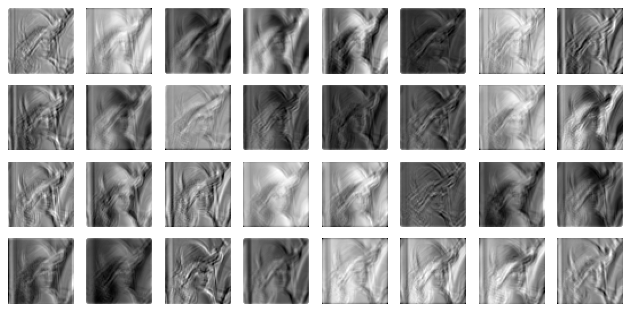

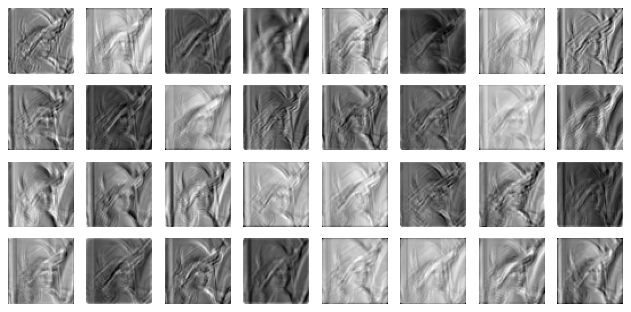

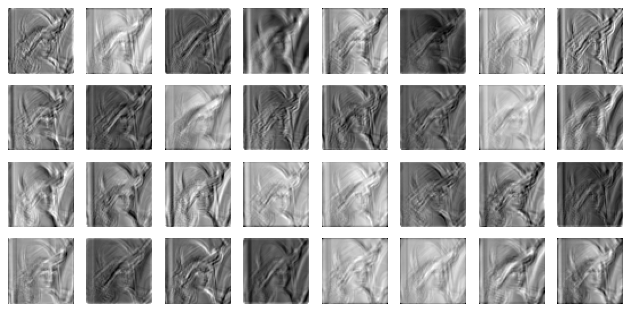

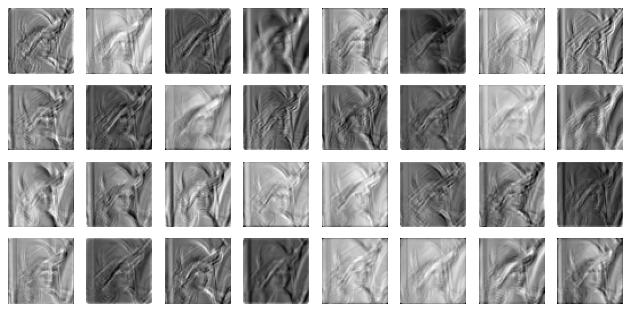

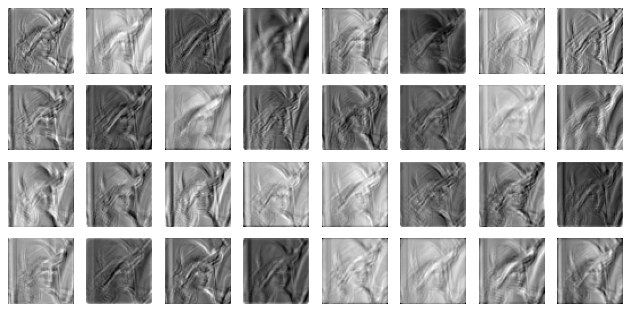

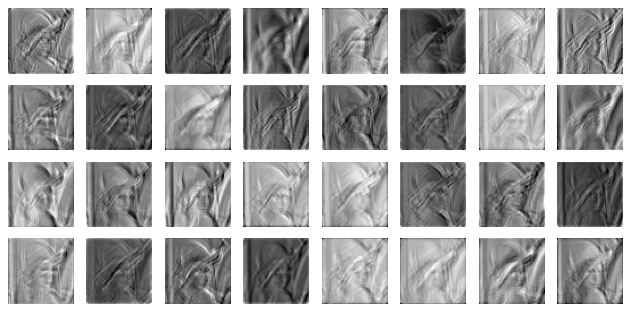

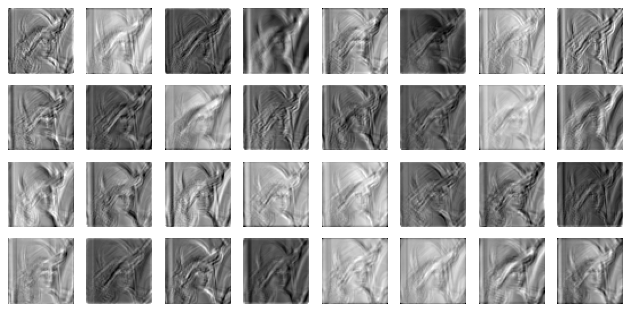

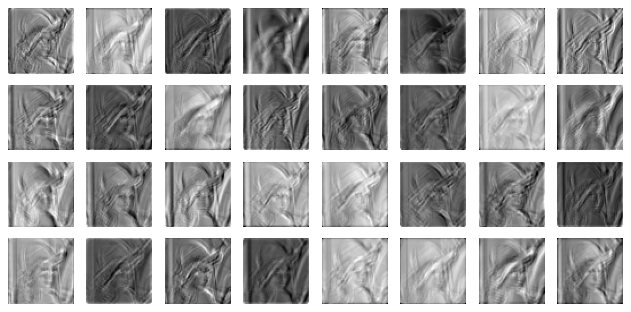

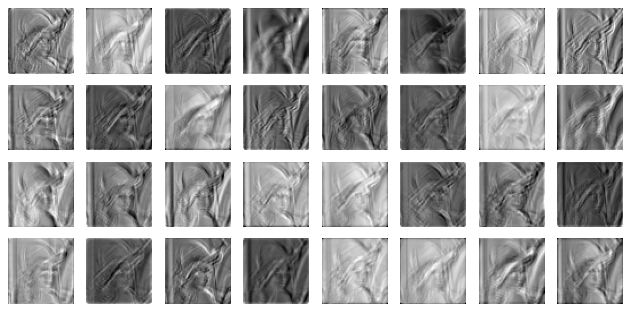

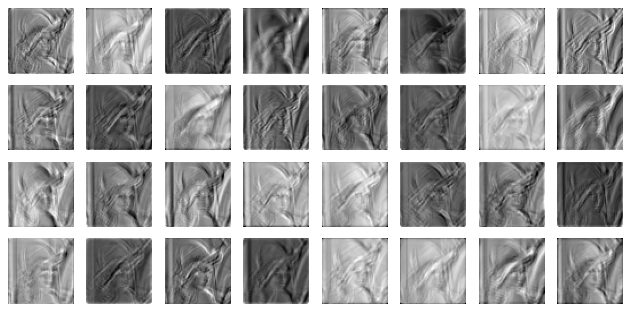

In [22]:

frames = []
for output in outputs:
    image = Image.fromarray((output*255).astype(np.uint8),mode='L')
    frames.append(image)
frames[0].save('output.gif', save_all=True, append_images=frames[1:], duration=300, loop=0)
frames = []
for output in latents:
    c,h,w = output.shape 
    ncols = 8
    fig, ax = plt.subplots(nrows=c//ncols, ncols=ncols, figsize=(1*ncols, 1*c//ncols),dpi=80 )
    for epoch in range(c//ncols):
        for j in range(ncols):
            ax[epoch,j].axis('off')
            ax[epoch,j].imshow(output[epoch*ncols+j],cmap='gray',vmin=output[epoch*ncols+j].min(), vmax=output[epoch*ncols+j].max())
    fig.tight_layout()
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    frames.append(image)
frames[0].save('latent.gif', save_all=True, append_images=frames[1:], duration=300, loop=0)




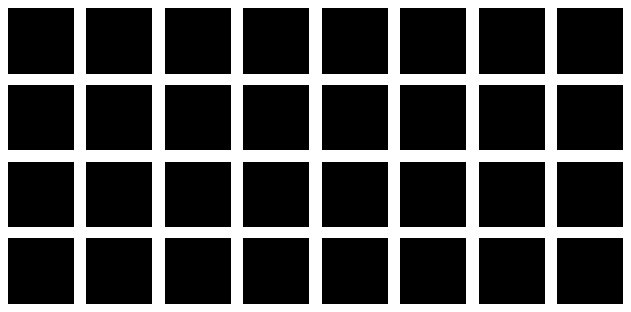

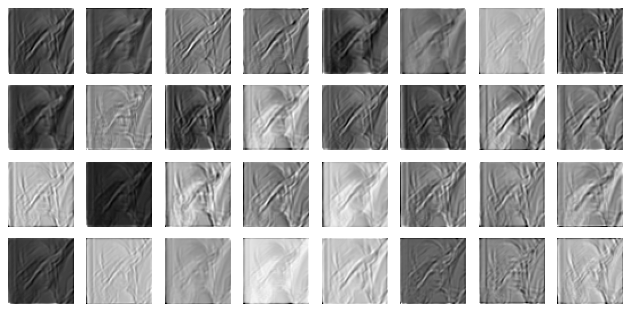

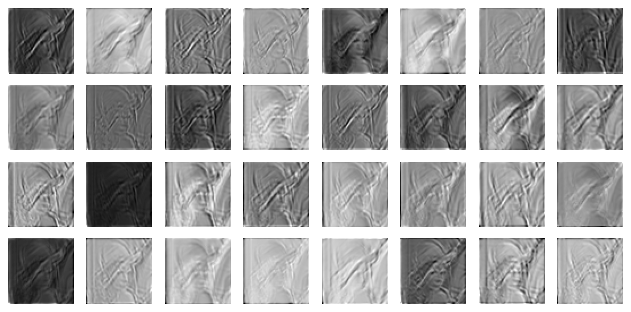

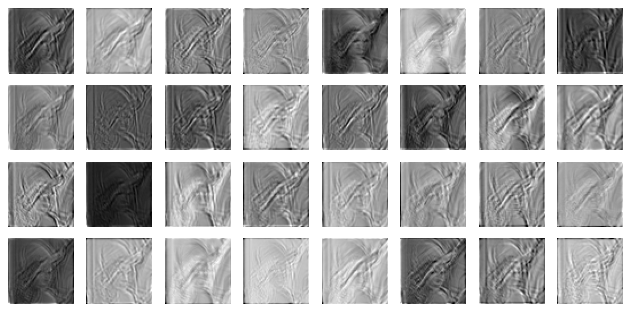

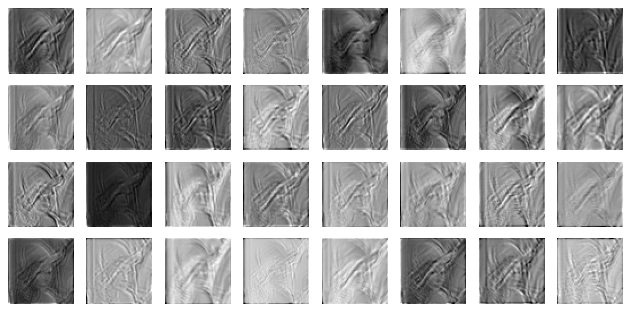

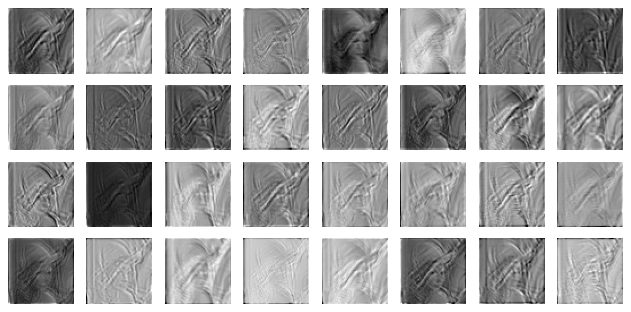

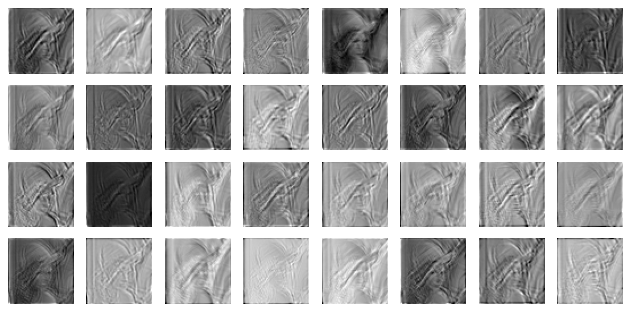

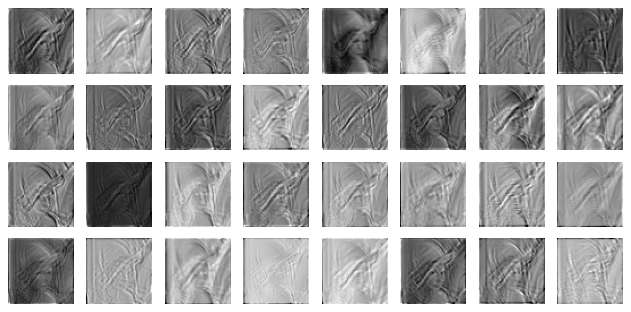

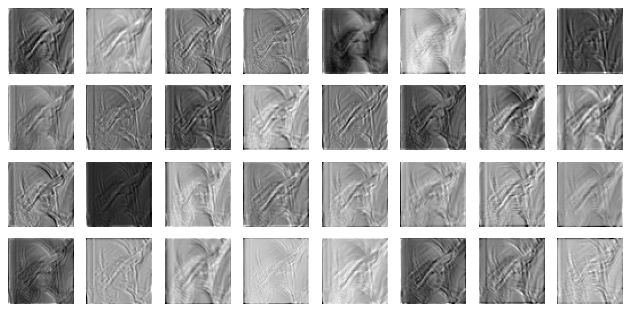

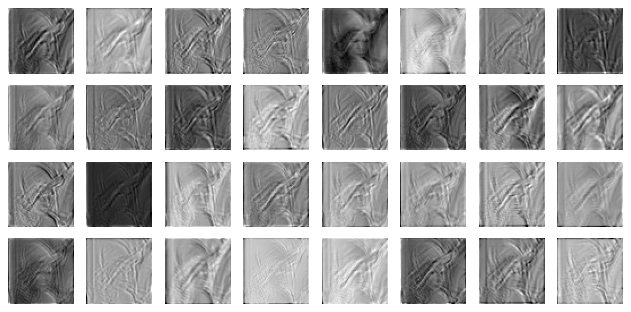

In [246]:
#plot latent in ResNet
frames = []
if model_name == 'ResNet':
    for output in res_latents:
        c,h,w = output.shape 
        ncols = 8
        fig, ax = plt.subplots(nrows=c//ncols, ncols=ncols, figsize=(1*ncols, 1*c//ncols),dpi=80 )
        for epoch in range(c//ncols):
            for j in range(ncols):
                ax[epoch,j].axis('off')
                ax[epoch,j].imshow(output[epoch*ncols+j],cmap='gray',vmin=output[epoch*ncols+j].min(), vmax=output[epoch*ncols+j].max())
        fig.tight_layout()
        fig.canvas.draw()
        image = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
        frames.append(image)
frames[0].save('residual_latent.gif', save_all=True, append_images=frames[1:], duration=300, loop=0)

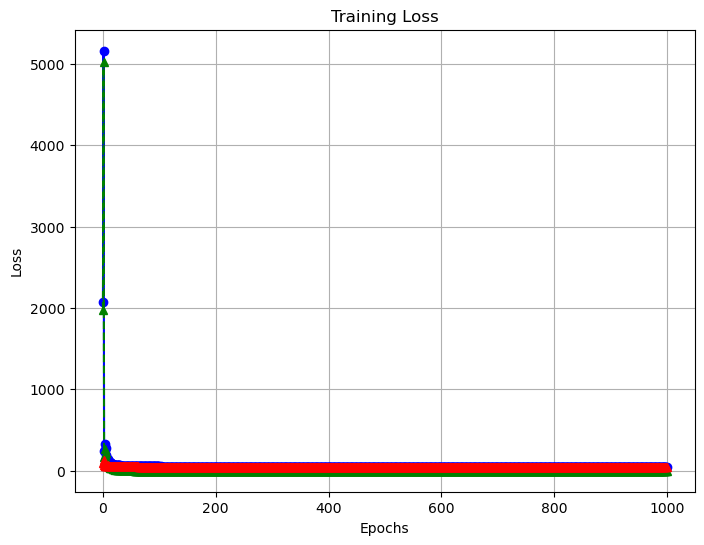

Text(0.5, 1.0, 'Output')

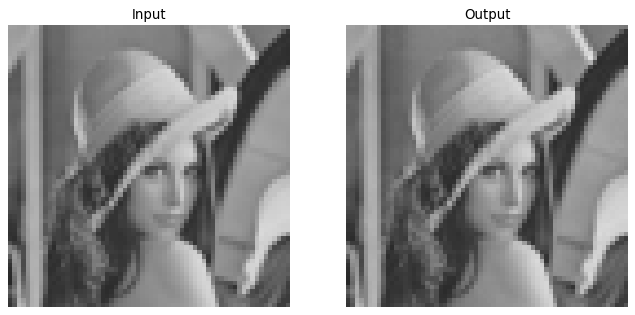

In [23]:
#plot training curve
plt.figure(figsize=(8, 6))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Total')
plt.plot(recon_losses, marker='^', linestyle='dashed', color='g', label='Reconstruction')
plt.plot(regu_losses, marker='^', linestyle='dashed', color='r', label='Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# Result Visualization
input = Image.open('Dataset/train/lena.jpg')
input = train_data_transform(input).unsqueeze(0).to(device)
with torch.no_grad():
    output,_ = model(input)
    
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),dpi=80 )
ax[0].imshow(input.squeeze().cpu().detach().numpy(),cmap='gray',vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('Input')
ax[1].imshow(output.squeeze().cpu().detach().numpy(),cmap='gray',vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title('Output')